# Célula 1 - Título / descrição (markdown)
"""
# Previsão de carga em 50 plantas industriais
Projeto de modelagem de séries temporais para entender e prever perfis de carga,
conectando com fator de carga, risco e oportunidades de suavização.
"""
A intenção desse modelo é transformar a base de consumo horário em uma ferramenta prática para prever carga futura por planta e gerar insumos objetivos para decisões de gestão de energia.

Objetivo geral
Prever a carga elétrica 1 hora à frente para cada uma das 50 plantas, usando histórico de consumo e variáveis de tempo como entrada.​

Criar um pipeline de machine learning reutilizável (ingestão, features, split temporal, baseline e modelo) que possa depois receber clima e, mais à frente, dados de hidrogênio e processo industrial.​

Propósito técnico
Sair de uma análise puramente descritiva da série (gráficos, médias, histogramas) para um modelo preditivo que aprenda padrões de horário, dia da semana, sazonalidade e comportamento de cada planta.​

Comparar o desempenho de modelos de ML (Random Forest com features de tempo e lags) com uma baseline simples de persistência, mostrando claramente se a modelagem realmente agrega valor.​

Propósito de negócio
Apoiar decisões de smart energy: identificar janelas de maior risco de pico ou pior fator de carga, antecipando consumo para atuar em demanda contratada, despacho de geração própria ou armazenamento.​

Preparar terreno para integrar clima e, depois, indicadores de produção de hidrogênio renovável, conectando “quando e quanto” a planta consome com “quando e quanto” é mais vantajoso produzir H₂ ou operar sistemas de energia renovável.​


Uso no meu portfólio
Servir como MVP forte para mostrar domínio de: engenharia de atributos em séries temporais, validação temporal, comparação de modelos e leitura de resultado com foco em negócio.​

Ser a base para próximos notebooks (carga+clima, carga+clima+hidrogênio), compondo um case completo de analytics para setor de energia/indústria que você pode apresentar para empresas ou em publicações

In [220]:
#  - Imports principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [221]:
# - Imports adicionais (modelos e tempo)
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

import datetime as dt


In [222]:
#  - Configurações de plot e opções
plt.style.use("seaborn-v0_8")
sns.set_palette("viridis")
pd.set_option("display.max_columns", 50)


In [223]:
# Caminho/entrada de dados
DATA_PATH = "../input/load-profile-data-of-50-industrial-plants"


In [224]:
DATA_PATH = "/content"

df_2016 = pd.read_csv(f"{DATA_PATH}/LoadProfile_20IPs_2016.csv",
                      sep=";", header=1, low_memory=False)
df_2017 = pd.read_csv(f"{DATA_PATH}/LoadProfile_30IPs_2017.csv",
                      sep=";", header=1, low_memory=False)

In [225]:
df_2016.head(), df_2017.head()

(            Time stamp  LG 1    LG 2    LG 3   LG 4   LG 5  LG 6  LG 7  LG 8  \
 0  01.01.2016 00:15:00    39  332.16  10.552  416.0  13.12  0.12   6.0   120   
 1  01.01.2016 00:30:00    41  321.36  10.300  418.4  13.12  0.24   6.0   116   
 2  01.01.2016 00:45:00    39  336.48  10.348  419.6  13.76  0.12   6.0   108   
 3  01.01.2016 01:00:00    40  319.20  10.600  422.0  13.44  0.12   8.0   112   
 4  01.01.2016 01:15:00    39  322.80  10.148  418.8  13.44  0.24   6.0   120   
 
    LG 9  LG 10  LG 11   LG 12  LG 13  LG 14   LG 15  LG 16  LG 17  LG 18  \
 0    70  38.52    0.0  27.400   29.6   65.0  2462.4  6.200   0.96   25.8   
 1    74  39.36    0.0  25.448   30.4   66.0  2462.4  6.200   0.90   34.2   
 2    68  39.84    0.0  27.000   30.4   68.0  2459.2  5.876   0.90   38.4   
 3    80  39.24    0.0  27.552   29.6   67.0  2451.2  6.200   1.02   19.8   
 4    72  38.52  272.0  24.900   31.2   66.0  2436.8  6.200   0.90   16.8   
 
    LG 19  LG 20  
 0  11.46    220  
 1  11.32 

In [226]:
# A célula 'jGZpkABf2a0W' já carrega os dados com 'header=1', então as colunas estão corretas.
# As linhas que redefinem colunas de .iloc[0] e removem [1:] são desnecessárias e causam DataFrames vazios.
# Vamos manter apenas o tratamento da coluna 'timestamp' e a conversão das colunas 'LG' para float.

# renomear coluna de tempo (agora 'Time stamp' deve existir no DataFrame)
df_2016 = df_2016.rename(columns={"Time stamp": "timestamp"})
df_2017 = df_2017.rename(columns={"Time stamp": "timestamp"})

# Remover ' b' da coluna 'timestamp' e outros espaços em branco antes da conversão
# Usamos .astype(str) para garantir que a coluna seja string antes de usar métodos .str
df_2016["timestamp"] = df_2016["timestamp"].astype(str).str.replace(' b', '', regex=False).str.strip()
df_2017["timestamp"] = df_2017["timestamp"].astype(str).str.replace(' b', '', regex=False).str.strip()

# Converter a coluna 'timestamp' para objetos datetime, permitindo inferência do formato e dayfirst.
# errors='coerce' transformará valores não analisáveis em NaT (Not a Time).
df_2016["timestamp"] = pd.to_datetime(df_2016["timestamp"], dayfirst=True, errors='coerce')
df_2017["timestamp"] = pd.to_datetime(df_2017["timestamp"], dayfirst=True, errors='coerce')

# Remover linhas onde a conversão de timestamp falhou (resultou em NaT)
df_2016.dropna(subset=['timestamp'], inplace=True)
df_2017.dropna(subset=['timestamp'], inplace=True)

# garantir que as colunas LG* sejam float
for df_tmp in (df_2016, df_2017):
    for col in df_tmp.columns:
        if col != "timestamp":
            df_tmp[col] = (
                df_tmp[col]
                .astype(str)
                .str.replace(",", ".", regex=False)
                .replace("", np.nan)
                .astype(float)
            )


In [227]:
df_2016.head(), df_2017.head()

(            timestamp  LG 1    LG 2    LG 3   LG 4   LG 5  LG 6  LG 7   LG 8  \
 0 2016-01-01 00:15:00  39.0  332.16  10.552  416.0  13.12  0.12   6.0  120.0   
 1 2016-01-01 00:30:00  41.0  321.36  10.300  418.4  13.12  0.24   6.0  116.0   
 2 2016-01-01 00:45:00  39.0  336.48  10.348  419.6  13.76  0.12   6.0  108.0   
 3 2016-01-01 01:00:00  40.0  319.20  10.600  422.0  13.44  0.12   8.0  112.0   
 4 2016-01-01 01:15:00  39.0  322.80  10.148  418.8  13.44  0.24   6.0  120.0   
 
    LG 9  LG 10  LG 11   LG 12  LG 13  LG 14   LG 15  LG 16  LG 17  LG 18  \
 0  70.0  38.52    0.0  27.400   29.6   65.0  2462.4  6.200   0.96   25.8   
 1  74.0  39.36    0.0  25.448   30.4   66.0  2462.4  6.200   0.90   34.2   
 2  68.0  39.84    0.0  27.000   30.4   68.0  2459.2  5.876   0.90   38.4   
 3  80.0  39.24    0.0  27.552   29.6   67.0  2451.2  6.200   1.02   19.8   
 4  72.0  38.52  272.0  24.900   31.2   66.0  2436.8  6.200   0.90   16.8   
 
    LG 19  LG 20  
 0  11.46  220.0  
 1  11.32 

In [ ]:
# Esta célula é um duplicado da célula adwf0e9o3rS6 que faz o pré-processamento de df_2016 e df_2017.
# Sua reexecução causa a perda de dados, pois tenta reprocessar uma coluna de datetime de forma destrutiva.
# O código foi comentado para evitar essa perda de dados.
# df_2016 = df_2016.rename(columns={"Time stamp": "timestamp"})
# df_2017 = df_2017.rename(columns={"Time stamp": "timestamp"})

# # Remover ' b' e espaços em branco das colunas 'timestamp' antes da conversão
# df_2016["timestamp"] = df_2016["timestamp"].astype(str).str.replace(' b', '', regex=False).str.strip()
# df_2017["timestamp"] = df_2017["timestamp"].astype(str).str.replace(' b', '', regex=False).str.strip()

# # Converter a coluna 'timestamp' para objetos datetime, especificando o formato para robustez.
# df_2016["timestamp"] = pd.to_datetime(df_2016["timestamp"], format="%d.%m.%Y %H:%M:%S", errors='coerce')
# df_2017["timestamp"] = pd.to_datetime(df_2017["timestamp"], format="%d.%m.%Y %H:%M:%S", errors='coerce')

# # Remover linhas onde a conversão de timestamp falhou (resultou em NaT)
# df_2016.dropna(subset=['timestamp'], inplace=True)
# df_2017.dropna(subset=['timestamp'], inplace=True)

# for df_tmp in (df_2016, df_2017):
#     for col in df_tmp.columns:
#         if col != "timestamp":
#             df_tmp[col] = (
#                 df_tmp[col]
#                 .astype(str)
#                 .str.replace(",", ".", regex=False)
#                 .replace("", np.nan)
#                 .astype(float)
#             )

In [229]:
df_2016.head(), df_2017.head()

(            timestamp  LG 1    LG 2    LG 3   LG 4   LG 5  LG 6  LG 7   LG 8  \
 0 2016-01-01 00:15:00  39.0  332.16  10.552  416.0  13.12  0.12   6.0  120.0   
 1 2016-01-01 00:30:00  41.0  321.36  10.300  418.4  13.12  0.24   6.0  116.0   
 2 2016-01-01 00:45:00  39.0  336.48  10.348  419.6  13.76  0.12   6.0  108.0   
 3 2016-01-01 01:00:00  40.0  319.20  10.600  422.0  13.44  0.12   8.0  112.0   
 4 2016-01-01 01:15:00  39.0  322.80  10.148  418.8  13.44  0.24   6.0  120.0   
 
    LG 9  LG 10  LG 11   LG 12  LG 13  LG 14   LG 15  LG 16  LG 17  LG 18  \
 0  70.0  38.52    0.0  27.400   29.6   65.0  2462.4  6.200   0.96   25.8   
 1  74.0  39.36    0.0  25.448   30.4   66.0  2462.4  6.200   0.90   34.2   
 2  68.0  39.84    0.0  27.000   30.4   68.0  2459.2  5.876   0.90   38.4   
 3  80.0  39.24    0.0  27.552   29.6   67.0  2451.2  6.200   1.02   19.8   
 4  72.0  38.52  272.0  24.900   31.2   66.0  2436.8  6.200   0.90   16.8   
 
    LG 19  LG 20  
 0  11.46  220.0  
 1  11.32 

In [230]:
df_2016_long = df_2016.melt(
    id_vars="timestamp",
    var_name="plant_id",
    value_name="load_kW"
)

df_2017_long = df_2017.melt(
    id_vars="timestamp",
    var_name="plant_id",
    value_name="load_kW"
)

df = pd.concat([df_2016_long, df_2017_long], ignore_index=True)
df = df.sort_values(["plant_id", "timestamp"]).reset_index(drop=True)
df.head()


,timestamp,plant_id,load_kW
0,2017-01-01 00:15:00,LG 01,4.340
1,2017-01-01 00:30:00,LG 01,4.510
2,2017-01-01 00:45:00,LG 01,3.795
3,2017-01-01 01:00:00,LG 01,4.245
4,2017-01-01 01:15:00,LG 01,4.050


In [231]:
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek
df["month"] = df["timestamp"].dt.month
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)


In [232]:
def create_lag_features(data, lag_list, rolling_windows):
    for lag in lag_list:
        data[f"load_lag_{lag}"] = data.groupby("plant_id")["load_kW"].shift(lag)
    for w in rolling_windows:
        data[f"load_rollmean_{w}"] = (
            data.groupby("plant_id")["load_kW"].shift(1).rolling(w).mean()
        )
    return data

lag_list = [1, 2, 4, 8, 24]
rolling_windows = [4, 8, 24]

df = create_lag_features(df, lag_list, rolling_windows)
df_model = df.dropna().copy()


In [233]:
# Features de tempo
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek
df["month"] = df["timestamp"].dt.month
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

# Lags e médias móveis (15 min: 1 passo = 15 min)
def create_lag_features(data, lag_list, rolling_windows):
    for lag in lag_list:
        data[f"load_lag_{lag}"] = data.groupby("plant_id")["load_kW"].shift(lag)
    for w in rolling_windows:
        data[f"load_rollmean_{w}"] = (
            data.groupby("plant_id")["load_kW"].shift(1).rolling(w).mean()
        )
    return data

lag_list = [1, 2, 4, 8, 24]      # 15, 30, 60, 120, 360 min atrás
rolling_windows = [4, 8, 24]     # média de 1h, 2h, 6h

df = create_lag_features(df, lag_list, rolling_windows)
df_model = df.dropna().copy()


In [234]:
# Ordenar
df_model = df_model.sort_values(["plant_id", "timestamp"])

# Split temporal (70/15/15)
cutoff_train = df_model["timestamp"].quantile(0.7)
cutoff_val = df_model["timestamp"].quantile(0.85)

train = df_model[df_model["timestamp"] <= cutoff_train]
val = df_model[(df_model["timestamp"] > cutoff_train) & (df_model["timestamp"] <= cutoff_val)]
test = df_model[df_model["timestamp"] > cutoff_val]

TARGET_COL = "load_kW"
FEATURE_COLS = [c for c in df_model.columns if c not in ["timestamp", TARGET_COL]]

X_train, y_train = train[FEATURE_COLS], train[TARGET_COL]
X_val, y_val = val[FEATURE_COLS], val[TARGET_COL]
X_test, y_test = test[FEATURE_COLS], test[TARGET_COL]


In [235]:
print("len(baseline_val) :", len(baseline_val))
print("NaNs em baseline_val:", baseline_val.isna().sum())
print("len(valid_val_idx)  :", len(valid_val_idx))
print("len(y_val)          :", len(y_val))

print("len(baseline_test)  :", len(baseline_test))
print("NaNs em baseline_test:", baseline_test.isna().sum())
print("len(valid_test_idx) :", len(valid_test_idx))
print("len(y_test)         :", len(y_test))


len(baseline_val) : 350010
NaNs em baseline_val: 0
len(valid_val_idx)  : 350010
len(y_val)          : 262530
len(baseline_test)  : 349980
NaNs em baseline_test: 0
len(valid_test_idx) : 349980
len(y_test)         : 262500


In [236]:
print(len(train), len(val), len(test))
print(train["timestamp"].min(), train["timestamp"].max())
print(val["timestamp"].min(), val["timestamp"].max())
print(test["timestamp"].min(), test["timestamp"].max())


1225154 262530 262500
2016-01-01 06:15:00 2017-07-01 16:45:00
2017-07-01 17:00:00 2017-09-30 20:30:00
2017-09-30 20:45:00 2017-12-30 23:00:00


In [237]:
df_model = df_model.sort_values(["plant_id", "timestamp"])

cutoff_train = df_model["timestamp"].quantile(0.6)
cutoff_val   = df_model["timestamp"].quantile(0.8)

train = df_model[df_model["timestamp"] <= cutoff_train]
val   = df_model[(df_model["timestamp"] > cutoff_train) & (df_model["timestamp"] <= cutoff_val)]
test  = df_model[df_model["timestamp"] > cutoff_val]


In [238]:
X_train, y_train = train[FEATURE_COLS], train[TARGET_COL]
X_val, y_val     = val[FEATURE_COLS],   val[TARGET_COL]
X_test, y_test   = test[FEATURE_COLS],  test[TARGET_COL]


In [239]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [240]:
import os
os.listdir("/content")

['.config',
 'LoadProfile_30IPs_2017.csv',
 'LoadProfile_20IPs_2016.csv',
 'sample_data']

In [241]:
print("df_model:", df_model.shape)
print("train  :", train.shape)
print("val    :", val.shape)
print("test   :", test.shape)

print("X_train:", X_train.shape)
print("X_val  :", X_val.shape)
print("X_test :", X_test.shape)


df_model: (1750184, 15)
train  : (1050134, 15)
val    : (350040, 15)
test   : (350010, 15)
X_train: (1050134, 13)
X_val  : (350040, 13)
X_test : (350010, 13)


In [242]:
df.isna().mean()
df.shape


(1754120, 15)

In [243]:
df = df.sort_values(["plant_id", "timestamp"])

def create_lag_features(data, lag_list, rolling_windows):
    for lag in lag_list:
        data[f"load_lag_{lag}"] = data.groupby("plant_id")["load_kW"].shift(lag)
    for w in rolling_windows:
        data[f"load_rollmean_{w}"] = (
            data.groupby("plant_id")["load_kW"].shift(1).rolling(w).mean()
        )
    return data

lag_list = [1, 2, 4]       # começa só com lags curtos
rolling_windows = [4]      # e uma média móvel simples

df = create_lag_features(df, lag_list, rolling_windows)

print("Antes do dropna:", df.shape)
print(df.isna().mean())


Antes do dropna: (1754120, 15)
timestamp           0.000000
plant_id            0.000000
load_kW             0.001710
hour                0.000000
dayofweek           0.000000
month               0.000000
is_weekend          0.000000
load_lag_1          0.001715
load_lag_2          0.001721
load_lag_4          0.001731
load_lag_8          0.001751
load_lag_24         0.001833
load_rollmean_4     0.001782
load_rollmean_8     0.001871
load_rollmean_24    0.002227
dtype: float64


In [244]:
# remover apenas as primeiras linhas de cada planta (onde faltam lags)
lag_list = [1, 2, 4, 8, 24]

df_model = (
    df.sort_values(["plant_id", "timestamp"])
      .groupby("plant_id")
      .apply(lambda g: g.iloc[max(lag_list):])  # corta primeiras N linhas
      .reset_index(drop=True)
)

print("df_model antes do dropna:", df_model.shape)
print(df_model.isna().mean())


/tmp/ipython-input-605102046.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.iloc[max(lag_list):])  # corta primeiras N linhas


df_model antes do dropna: (1753184, 15)
timestamp           0.000000
plant_id            0.000000
load_kW             0.001711
hour                0.000000
dayofweek           0.000000
month               0.000000
is_weekend          0.000000
load_lag_1          0.001694
load_lag_2          0.001677
load_lag_4          0.001643
load_lag_8          0.001574
load_lag_24         0.001300
load_rollmean_4     0.001694
load_rollmean_8     0.001694
load_rollmean_24    0.001694
dtype: float64


In [245]:
HORIZON = 4  # 4 passos de 15 min = 1 hora

df = df.sort_values(["plant_id", "timestamp"])

# alvo: carga 1h à frente
df["target_1h"] = df.groupby("plant_id")["load_kW"].shift(-HORIZON)


In [246]:
# definir horizonte de 1 hora (4 passos de 15 min)
HORIZON = 4

df = df.sort_values(["plant_id", "timestamp"])

# alvo: carga 1 hora à frente
df["target_1h"] = df.groupby("plant_id")["load_kW"].shift(-HORIZON)

print(df[["timestamp", "plant_id", "load_kW", "target_1h"]].head())
print(df.columns)


            timestamp plant_id  load_kW  target_1h
0 2017-01-01 00:15:00    LG 01    4.340       4.05
1 2017-01-01 00:30:00    LG 01    4.510       3.77
2 2017-01-01 00:45:00    LG 01    3.795       3.11
3 2017-01-01 01:00:00    LG 01    4.245       1.99
4 2017-01-01 01:15:00    LG 01    4.050       1.69
Index(['timestamp', 'plant_id', 'load_kW', 'hour', 'dayofweek', 'month',
       'is_weekend', 'load_lag_1', 'load_lag_2', 'load_lag_4', 'load_lag_8',
       'load_lag_24', 'load_rollmean_4', 'load_rollmean_8', 'load_rollmean_24',
       'target_1h'],
      dtype='object')


In [247]:
lag_list = [1, 2, 4, 8, 24]

df_model = (
    df.groupby("plant_id")
      .apply(lambda g: g.iloc[max(lag_list):-HORIZON])  # corta início e fim
      .reset_index(drop=True)
)

print("df_model antes do dropna:", df_model.shape)
print(df_model.isna().mean())

df_model = df_model.dropna()
print("df_model final:", df_model.shape)


/tmp/ipython-input-1511974592.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.iloc[max(lag_list):-HORIZON])  # corta início e fim


df_model antes do dropna: (1753028, 16)
timestamp           0.000000
plant_id            0.000000
load_kW             0.001643
hour                0.000000
dayofweek           0.000000
month               0.000000
is_weekend          0.000000
load_lag_1          0.001626
load_lag_2          0.001609
load_lag_4          0.001574
load_lag_8          0.001506
load_lag_24         0.001232
load_rollmean_4     0.001626
load_rollmean_8     0.001626
load_rollmean_24    0.001626
target_1h           0.001711
dtype: float64
df_model final: (1750028, 16)


In [248]:
df_model = df_model.sort_values(["plant_id", "timestamp"])

cutoff_train = df_model["timestamp"].quantile(0.6)
cutoff_val   = df_model["timestamp"].quantile(0.8)

train = df_model[df_model["timestamp"] <= cutoff_train]
val   = df_model[(df_model["timestamp"] > cutoff_train) & (df_model["timestamp"] <= cutoff_val)]
test  = df_model[df_model["timestamp"] > cutoff_val]

TARGET_COL   = "target_1h"
FEATURE_COLS = [c for c in df_model.columns if c not in ["timestamp", TARGET_COL]]

X_train, y_train = train[FEATURE_COLS], train[TARGET_COL]
X_val,   y_val   = val[FEATURE_COLS],   val[TARGET_COL]
X_test,  y_test  = test[FEATURE_COLS],  test[TARGET_COL]

print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)


X_train: (1050038, 14) X_val: (350010, 14) X_test: (349980, 14)


In [249]:
# Remover os poucos NaNs restantes
df_model = df_model.dropna()
print("df_model final:", df_model.shape)

# Ordenar e definir cortes temporais
df_model = df_model.sort_values(["plant_id", "timestamp"])

cutoff_train = df_model["timestamp"].quantile(0.6)
cutoff_val   = df_model["timestamp"].quantile(0.8)

train = df_model[df_model["timestamp"] <= cutoff_train]
val   = df_model[(df_model["timestamp"] > cutoff_train) & (df_model["timestamp"] <= cutoff_val)]
test  = df_model[df_model["timestamp"] > cutoff_val]

TARGET_COL  = "target_1h" # Certifique-se de que esta é a coluna correta do target
FEATURE_COLS = [c for c in df_model.columns if c not in ["timestamp", TARGET_COL]]

X_train, y_train = train[FEATURE_COLS], train[TARGET_COL]
X_val,   y_val   = val[FEATURE_COLS],   val[TARGET_COL]
X_test,  y_test  = test[FEATURE_COLS],  test[TARGET_COL]

print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)


df_model final: (1750028, 16)
X_train: (1050038, 14) X_val: (350010, 14) X_test: (349980, 14)


In [250]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

baseline_val  = val.groupby("plant_id")["load_kW"].shift(1)
baseline_test = test.groupby("plant_id")["load_kW"].shift(1)

valid_val_idx  = baseline_val.dropna().index
valid_test_idx = baseline_test.dropna().index

y_val_f         = y_val.loc[valid_val_idx]
baseline_val_f  = baseline_val.loc[valid_val_idx]
y_test_f        = y_test.loc[valid_test_idx]
baseline_test_f = baseline_test.loc[valid_test_idx]

mae_base_val  = mean_absolute_error(y_val_f,  baseline_val_f)
mae_base_test = mean_absolute_error(y_test_f, baseline_test_f)

print("Baseline persistência - MAE val :", mae_base_val)
print("Baseline persistência - MAE test:", mae_base_test)


Baseline persistência - MAE val : 2.3639100262872166
Baseline persistência - MAE test: 2.285167453921989


In [ ]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=50,
        max_depth=8,
        random_state=42,
        n_jobs=-1
    ))
])


In [257]:
X_train_sample = X_train.sample(500_000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

rf_pipeline.set_params(
    regressor__n_estimators=30,
    regressor__max_depth=8
)

rf_pipeline.fit(X_train_sample, y_train_sample)


/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['plant_id'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=8, n_estimators=30, n_jobs=-1,
                                       random_state=42))])

In [258]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def eval_regression(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5  # raiz na mão
    mape = (np.abs((y_true - y_pred) / y_true)
              .replace([np.inf, -np.inf], np.nan)
              .mean() * 100)
    print(f"{label} - MAE: {mae:.3f} | RMSE: {rmse:.3f} | MAPE: {mape:.2f}%")


In [259]:
val_pred  = rf_pipeline.predict(X_val)
test_pred = rf_pipeline.predict(X_test)

eval_regression(y_val,  val_pred,  "RF - Val")
eval_regression(y_test, test_pred, "RF - Test")

print("Baseline persistência - MAE val :", mae_base_val)
print("Baseline persistência - MAE test:", mae_base_test)


RF - Val - MAE: 2.816 | RMSE: 5.513 | MAPE: 97.54%
RF - Test - MAE: 2.750 | RMSE: 5.543 | MAPE: 102.24%
Baseline persistência - MAE val : 2.3639100262872166
Baseline persistência - MAE test: 2.285167453921989


/tmp/ipython-input-58480437.py:13: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  .last("7D"))


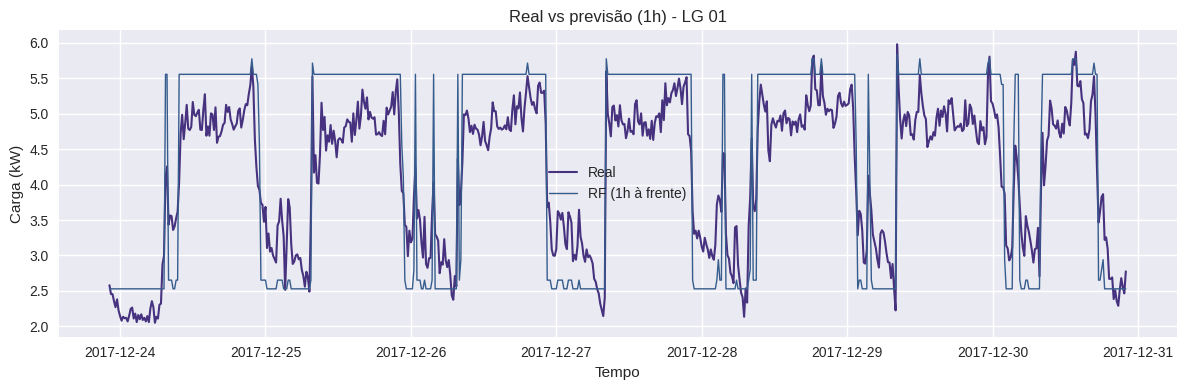

In [255]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Montar base de teste com previsões
test_results = test[["plant_id", "timestamp", "load_kW"]].copy()
test_results["pred_rf"] = test_pred

# 2) Escolher uma planta e ver 7 dias
plant_focus = test_results["plant_id"].unique()[0]
df_focus = (test_results[test_results["plant_id"] == plant_focus]
            .set_index("timestamp")
            .sort_index()
            .last("7D"))

plt.figure(figsize=(12,4))
plt.plot(df_focus.index, df_focus["load_kW"], label="Real", linewidth=1.5)
plt.plot(df_focus.index, df_focus["pred_rf"], label="RF (1h à frente)", linewidth=1)
plt.legend()
plt.title(f"Real vs previsão (1h) - {plant_focus}")
plt.xlabel("Tempo")
plt.ylabel("Carga (kW)")
plt.tight_layout()
plt.show()


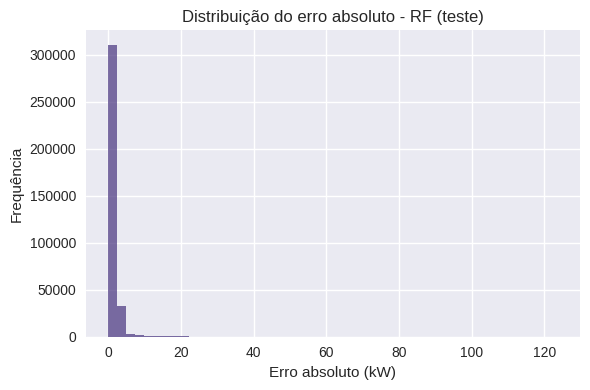

In [256]:
err_rf = np.abs(test_results["pred_rf"] - test_results["load_kW"])

plt.figure(figsize=(6,4))
plt.hist(err_rf, bins=50, alpha=0.7)
plt.xlabel("Erro absoluto (kW)")
plt.ylabel("Frequência")
plt.title("Distribuição do erro absoluto - RF (teste)")
plt.tight_layout()
plt.show()


Etapa: Preparação da base de modelagem
Leitura dos arquivos de 2016 e 2017, ajuste do cabeçalho e conversão da coluna de tempo para datetime.
---------------------------------------------
Transformação dos dados de formato “wide” (uma coluna por planta) para formato “long” com timestamp, plant_id e load_kW, unificando as 50 plantas em um único DataFrame.
---------------------------------------------
Etapa: Criação de features e do alvo
Geração de features temporais (hora, dia da semana, mês, fim de semana) para capturar padrões de operação.
---------------------------------------------
Criação de lags e médias móveis da carga para incorporar memória da série.
---------------------------------------------
Definição do alvo target_1h, representando a carga 1 hora à frente para cada planta, a partir da série load_kW.
---------------------------------------------
Etapa: Montagem do df_model e split temporal
Corte inicial e final por planta para remover linhas sem lags ou sem alvo válido, formando o df_model com todas as features prontas.
---------------------------------------------
Remoção dos poucos NaN restantes e ordenação por plant_id e timestamp.
---------------------------------------------
Divisão temporal da base em treino, validação e teste (≈60/20/20) e criação de X_train, X_val, X_test e y_train, y_val, y_test usando target_1h como variável alvo.
---------------------------------------------
Etapa: Baseline e Random Forest com pipeline
Construção da baseline de persistência (previsão para 1 h à frente igual à carga atual) e cálculo de MAE de validação e teste.
---------------------------------------------
Criação de um Pipeline com ColumnTransformer (One-Hot Encoding de plant_id + features numéricas em passthrough) e RandomForestRegressor.
---------------------------------------------
Treinamento do modelo com amostra de treino (X_train_sample, y_train_sample) e avaliação com eval_regression em validação e teste, comparando diretamente o desempenho do Random Forest com a baseline.
---------------------------------------------